In [109]:
import sys
import os
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

In [3]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.00,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.00,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.00,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.50,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.00,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are No NAN values

In [6]:
profile = pp.ProfileReport(df)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Our dataset has 918 samples.

# 1. Preprocessing

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = df.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

In [10]:
df1.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.00,2,0
1,49,0,2,160,180,0,1,156,0,1.00,1,1
2,37,1,1,130,283,0,2,98,0,0.00,2,0
3,48,0,0,138,214,0,1,108,1,1.50,1,1
4,54,1,2,150,195,0,1,122,0,0.00,2,0


In [11]:
categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','FastingBS','ST_Slope','HeartDisease']
numerical_features = ['Age','RestingBP','MaxHR','Cholesterol','Oldpeak']

# 2. Data Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']]) 
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.43,1,1,0.41,0.83,0,1,1.38,0,0.30,2,0
1,-0.48,0,2,1.49,-0.17,0,1,0.75,0,0.41,1,1
2,-1.75,1,1,-0.13,0.77,0,2,-1.53,0,0.30,2,0
3,-0.58,0,0,0.30,0.14,0,1,-1.13,1,0.47,1,1
4,0.05,1,2,0.95,-0.03,0,1,-0.58,0,0.30,2,0


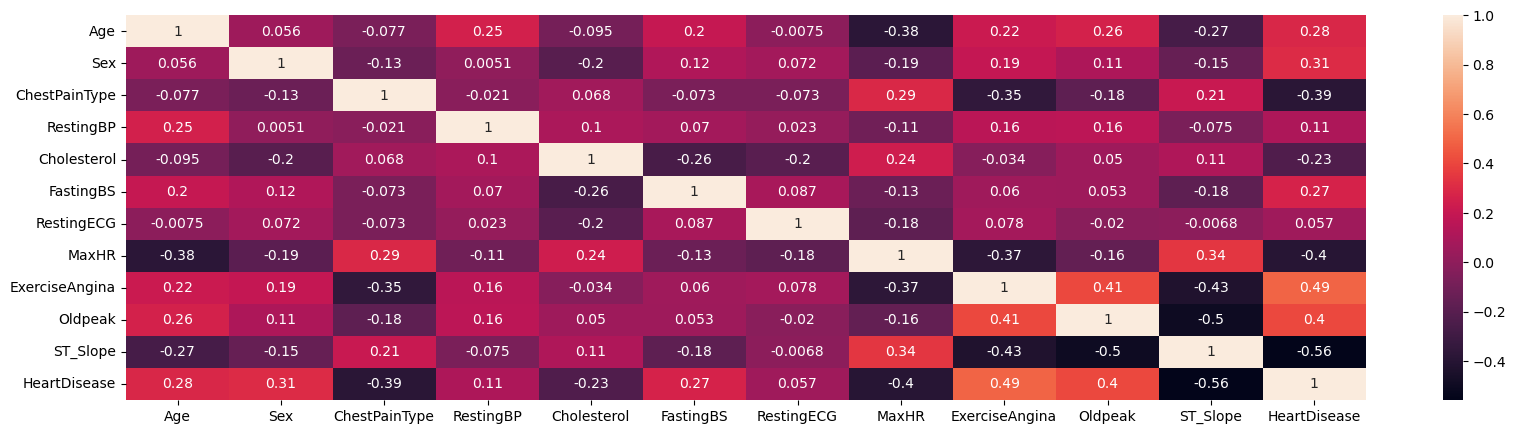

In [13]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),annot = True);

# 3. Feature Selection for Categorical Features

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

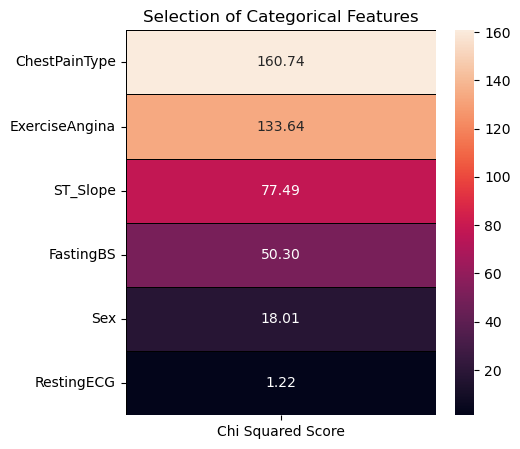

In [16]:
features = df1.loc[:,categorical_features[:-1]]
target = df1['HeartDisease']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,linewidths = 0.6,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

We can drop RestingECG as it has a very low chi2 score

# 4. Feature selection for numerical Features

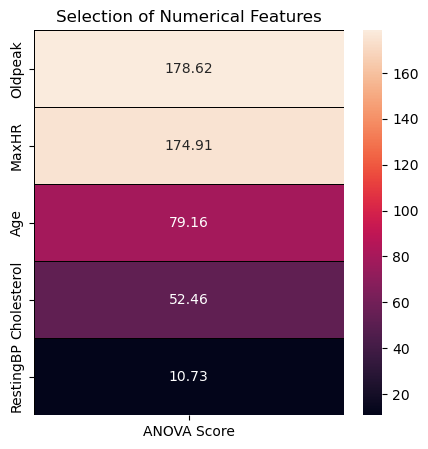

In [17]:
from sklearn.feature_selection import f_classif

features = df1.loc[:,numerical_features]
target = df1['HeartDisease']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.6,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

RestingBP can be dropped as it has very less ANOVA score

In [18]:
features = df1[df1.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 42)

# 5. Model Training

### 1. Support Vector Machine

In [19]:
svm = SVC()

In [20]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': ['auto','scale'],
              'kernel': ['linear','poly','rbf','sigmoid']
             }


In [21]:
gs_svm = GridSearchCV(  estimator = svm,
                        param_grid = param_grid, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
gs_svm.fit(x_train,y_train)

In [ ]:
gs_svm.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}

### 2. KNN

In [22]:
knn = KNeighborsClassifier()

In [23]:
knn_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [24]:
gs_knn = GridSearchCV(  estimator = knn,
                        param_grid = knn_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
gs_knn.fit(x_train,y_train)

In [ ]:
gs_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}

### 3. MLP

In [25]:
mlp_params = {
     'solver': ['adam'],
     'learning_rate_init': [0.0001,0.01,0.1],
     'max_iter': [300],
     'hidden_layer_sizes': [(50,30,20,30,10), (400, 300, 200, 100), (400, 300, 200, 100, 50), (50, 40, 30, 20, 10), (20, 15, 10, 5)],
     'activation': ['logistic', 'tanh', 'relu'],
     'alpha': [0.0001, 0.001, 0.005],
     'early_stopping': [True, False]
     }

In [26]:
gs_mlp = GridSearchCV(  estimator = MLPClassifier(),
                        param_grid = mlp_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
gs_mlp.fit(x_train,y_train)

In [ ]:
mlp_proba = gs_mlp.predict_proba(x_test)
mlp_score = roc_auc_score(y_test, mlp_proba[:, 1])
print(f"ROC AUC: {mlp_score:.4f}")

In [ ]:
gs_mlp.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'early_stopping': True,
 'hidden_layer_sizes': (400, 400, 400, 400, 400),
 'learning_rate_init': 0.0001,
 'max_iter': 300,
 'solver': 'adam'}

### 4. Random Forest

In [27]:
rfc = RandomForestClassifier()

In [28]:
rfc_params = { 
    'n_estimators': [100, 150, 300, 500 ],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [29]:
gs_rfc = GridSearchCV(  estimator = rfc,
                        param_grid = rfc_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
gs_rfc.fit(x_train,y_train)

In [ ]:
rfc_proba = gs_rfc.predict_proba(x_test)
rfc_score = roc_auc_score(y_test, rfc_proba[:, 1])
print(f"ROC AUC: {rfc_score:.4f}")

In [ ]:
gs_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 150}

### 5. XGBoost

In [30]:
xgb = XGBClassifier(learning_rate = 0.02, objective='binary:logistic',nthread=4)

In [31]:
xgb_params = {
        'n_estimators' : [100,150,250],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'max_depth': [3, 4, 5],
        'subsample': [0.6, 0.8, 1.0]
        }

In [32]:
gs_xgb = GridSearchCV(  estimator = xgb,
                        param_grid = xgb_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1
                     )

In [ ]:
gs_xgb.fit(x_train,y_train)

In [ ]:
gs_xgb.best_score_

In [ ]:
y_proba = gs_xgb.predict_proba(x_test)

In [ ]:
xgb_score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {xgb_score:.4f}")

In [ ]:
gs_xgb.best_params_

{'gamma': 1.5,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 250,
 'subsample': 0.8}
 learning_rate = 0.02

### 6. CatBoost

In [35]:
cbc = CatBoostClassifier(loss_function='Logloss')

In [36]:
cbc_params = {'learning_rate': [0.03,0.05,0.1],
        'n_estimators' : [50,150,300,500],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,7,9]}

In [37]:
gs_cbc = GridSearchCV(  estimator = cbc,
                        param_grid = cbc_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1
                     )

In [ ]:
gs_cbc.fit(x_train,y_train)

In [ ]:
gs_cbc.best_score_

In [ ]:
y_probacbc = gs_cbc.predict_proba(x_test)

In [ ]:
cbc_score = roc_auc_score(y_test, y_probacbc[:, 1])
print(f"ROC AUC: {cbc_score:.4f}")

In [ ]:
gs_cbc.best_params_

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'n_estimators': 300}

## 7. AdaBoost

In [38]:
ada = AdaBoostClassifier(random_state = 42)

In [39]:
ada_params = {'learning_rate': [0.03,0.05,0.07,0.1],
        'n_estimators' : [100,200,300,400,500],
        'algorithm': ['SAMME', 'SAMME.R']
             }

In [40]:
gs_ada = GridSearchCV(  estimator = ada,
                        param_grid = ada_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1
                     )

In [ ]:
gs_ada.fit(x_train,y_train)

In [ ]:
y_proba_ada = gs_ada.predict_proba(x_test)

In [ ]:
ada_score = roc_auc_score(y_test, y_proba_ada[:, 1])
print(f"ROC AUC: {ada_score:.4f}")

In [ ]:
gs_ada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.03, 'n_estimators': 300}

## 8. Decision tree 

In [41]:
dt = DecisionTreeClassifier(random_state=42)

In [42]:
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [43]:
gs_dt = GridSearchCV(  estimator = dt,
                        param_grid = dt_params, 
                        cv = 5,
                        scoring = "roc_auc",
                        refit = True,
                        verbose = 1
                     )

In [ ]:
gs_dt.fit(x_train,y_train)

In [ ]:
y_proba_dt = gs_dt.predict_proba(x_test)

In [ ]:
dt_score = roc_auc_score(y_test, y_proba_dt[:, 1])
print(f"ROC AUC: {dt_score:.4f}")

In [ ]:
gs_dt.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}

## 9. Naive Bayes

In [44]:
nb = GaussianNB()

In [45]:
nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_nb = GridSearchCV(estimator=nb, 
                     param_grid=nb_params, 
                     cv=5,
                     verbose=1,
                     refit = True,
                     scoring='roc_auc')

In [ ]:
gs_nb.fit(x_train,y_train)

In [ ]:
gs_nb.best_params_

{'var_smoothing': 0.0015199110829529332}

## 10. Logistic regression

In [46]:
lr = LogisticRegression()

In [47]:
lr_params = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [1,2,3,4,5,6,7,8,9,10]
    }
]

In [48]:
gs_lr = GridSearchCV(estimator=lr, 
                     param_grid=lr_params, 
                     cv=5,
                     verbose=1,
                     refit = True,
                     scoring='roc_auc')

In [ ]:
gs_lr.fit(x_train,y_train)

In [ ]:
y_proba_lr = gs_lr.predict_proba(x_test)

In [ ]:
lr_score = roc_auc_score(y_test, y_proba_lr[:, 1])
print(f"ROC AUC: {lr_score:.4f}")

In [ ]:
gs_lr.best_estimator_

LogisticRegression(C=0.08858667904100823, max_iter=7, penalty='none',
                   solver='sag')

## 11.LightGBM [additional]

In [49]:
lgbm = LGBMClassifier()

In [50]:
lgbm_params = {
    'num_leaves': [5,10,20,30,50,100],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    }

In [51]:
gs_lgbm = GridSearchCV(estimator = lgbm, 
                     param_grid = lgbm_params, 
                     cv=5,
                     verbose = 0,
                     refit = True,
                     scoring='roc_auc')

In [ ]:
gs_lgbm.fit(x_train,y_train,verbose = False)

In [ ]:
y_proba_lgbm = gs_lgbm.predict_proba(x_test)
lgbm_score = roc_auc_score(y_test, y_proba_lgbm[:, 1])
print(f"ROC AUC: {lgbm_score:.4f}")

In [ ]:
gs_lgbm.best_estimator_

In [ ]:
gs_lgbm.best_params_

## -------------------------------------------------

## Stacking Classifier [Using best hyperparameters of base models]

In [101]:
def get_stacking():

  level0 = list()
  level0.append(('lr', LogisticRegression(C=0.08858667904100823, max_iter=7,solver='saga')))       
  level0.append(('knn', KNeighborsClassifier(metric = 'manhattan', n_neighbors = 15, weights = 'distance')))
  level0.append(('dt', DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,random_state=42)))
  level0.append(('svc', SVC(C = 10, gamma = 'auto', kernel = 'linear')))
  level0.append(('ada', AdaBoostClassifier(n_estimators = 300, learning_rate = 0.03, algorithm = 'SAMME.R')))
  level0.append(('cat', CatBoostClassifier(n_estimators = 300, depth = 6, l2_leaf_reg = 1, learning_rate = 0.03, verbose = False)))
  level0.append(('mlp', MLPClassifier(activation = 'relu', alpha = 0.0001, early_stopping = False,
                                     hidden_layer_sizes = (50, 30, 20, 30, 10),
                                     learning_rate_init = 0.0001,
                                     max_iter = 500,
                                     solver = 'adam')))
  level0.append(('xgb', XGBClassifier(n_estimators = 250, subsample = 0.8, min_child_weight = 1, max_depth = 3, gamma = 1.5, learning_rate = 0.02)))
  level0.append(('nb', GaussianNB(var_smoothing = 0.0015199110829529332)))
  level0.append(('rfc', RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = 6, criterion = 'entropy')))
               
 # Define meta learner model
               
  level1 = GaussianNB(var_smoothing = 0.0015199110829529332)
               
 # Define the stacking ensemble
               
  model = StackingClassifier(estimators=level0, final_estimator=level1, passthrough = True, stack_method = 'auto')
  return model

In [102]:
def get_models():
 models = dict()
 models['cat'] = CatBoostClassifier(n_estimators = 300, depth = 6, l2_leaf_reg = 1, learning_rate = 0.03,verbose=False)
 models['lr'] = LogisticRegression(C=0.08858667904100823, max_iter=7,solver='saga',verbose = 0)
 models['knn'] = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 15, weights = 'distance')
 models['dt'] = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,random_state=42)
 models['svm'] = SVC(C = 10, gamma = 'auto', kernel = 'linear')
 models['bayes'] = GaussianNB(var_smoothing = 0.0015199110829529332)
 models['ada'] = AdaBoostClassifier(n_estimators = 300, learning_rate = 0.03, algorithm = 'SAMME.R')
 models['mlp'] = MLPClassifier(activation = 'relu', alpha = 0.0001, early_stopping = False,
                                     hidden_layer_sizes = (50, 30, 20, 30, 10),
                                     learning_rate_init = 0.0001,
                                     max_iter = 500,
                                     solver = 'adam'
                                )
 models['xgb'] = XGBClassifier(n_estimators = 250, subsample = 0.8, min_child_weight = 1, max_depth = 3, gamma = 1.5, learning_rate = 0.02)
 models['rfc'] = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = 6, criterion = 'entropy')
 models['stacking'] = get_stacking()
 return models

In [103]:
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state=0)
 scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
 return scores

In [104]:
models = get_models()

In [110]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] =('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

 ROC_AUC [cat]: 0.932 +/- 0.019
 ROC_AUC [lr]: 0.911 +/- 0.025
 ROC_AUC [knn]: 0.923 +/- 0.023
 ROC_AUC [dt]: 0.900 +/- 0.024
 ROC_AUC [svm]: 0.911 +/- 0.025
 ROC_AUC [bayes]: 0.913 +/- 0.025
 ROC_AUC [ada]: 0.926 +/- 0.023
 ROC_AUC [mlp]: 0.927 +/- 0.021
 ROC_AUC [xgb]: 0.936 +/- 0.020
 ROC_AUC [rfc]: 0.931 +/- 0.021
 ROC_AUC [stacking]: 0.933 +/- 0.021


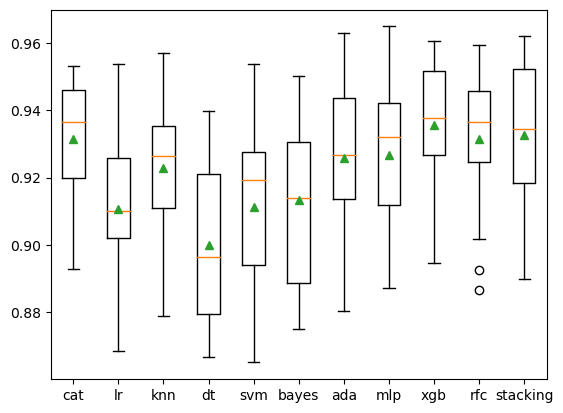

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


In [111]:
# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, features, target)
 results.append(scores)
 names.append(name)
 print(' ROC_AUC [%s]: %.3f +/- %.3f' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## HyperParameter Tuning the Stacked Ensemble [Very time consuming]

In [ ]:
clf1 = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 15, weights = 'distance')
clf2 = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = 6, criterion = 'entropy')
clf3 = GaussianNB(var_smoothing = 0.0015199110829529332)
clf4 = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,random_state=42)
clf5 = LGBMClassifier(lambda_l1=1.5, lambda_l2=1, min_data_in_leaf=50, num_leaves=5,reg_alpha=0.1)
clf6 = AdaBoostClassifier(n_estimators = 300, learning_rate = 0.03, algorithm = 'SAMME.R')
clf7 = CatBoostClassifier(n_estimators = 300, depth = 6, l2_leaf_reg = 1, learning_rate = 0.03, verbose = False)
clf8 = MLPClassifier(activation = 'relu', alpha = 0.0001, early_stopping = False,
                                     hidden_layer_sizes = (50, 30, 20, 30, 10),
                                     learning_rate_init = 0.0001,
                                     max_iter = 300,
                                     solver = 'adam')
clf9 = XGBClassifier(n_estimators = 250, subsample = 0.8, min_child_weight = 1, max_depth = 3, gamma = 1.5, learning_rate = 0.02)
clf10 = LogisticRegression(C=0.08858667904100823, max_iter=7,solver='sag')

meta_model = XGBClassifier()

sclf = StackingCVClassifier(classifiers=[clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9,clf10], 
                            meta_classifier= meta_model,
                            use_probas=True,
                            random_state=42)

In [ ]:
stack_params = {
        'meta_classifier__n_estimators' : [100,150,250],
        'meta_classifier__min_child_weight': [1, 5, 10],
        'meta_classifier__gamma': [0.5, 1, 1.5, 2],
        'meta_classifier__max_depth': [3, 4, 5],
        }

In [ ]:
gs_stack = GridSearchCV(estimator= sclf, 
                     param_grid=stack_params, 
                     cv=5,
                     verbose=1,
                     refit = True,
                     scoring='roc_auc')

In [ ]:
gs_stack.fit(x_train,y_train)

In [ ]:
cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('ROC_AUC: %.2f' % grid.best_score_)